In [43]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from spec_exam import Gen_spec, Calzetti
from spec_extract import Scale_spectra
from spec_tools import Photometry, Median_w_Error_cont, Median_w_Error, Likelihood_contours,Oldest_galaxy
import seaborn as sea
import re
from astropy.io import fits
from astropy.table import Table
from grizli import model as griz_model
from scipy.interpolate import interp1d
from spec_tools import Get_Sensitivity, Scale_model
import pysynphot as S
from time import time
import os
from glob import glob
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [65]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')
lzDB = galDB.query('z_grism < 1.5')
mzDB = galDB.query('1.5 < z_grism < 1.8')
hzDB = galDB.query('1.8 < z_grism < 2.1')
uhzDB = galDB.query('2.1 < z_grism')

lwa = np.load('../data/light_weight_scaling_3.npy')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

# AGE

In [71]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

ferrdb = pd.read_pickle('../../Quiescent_analysis/data/Q_ferreras.pkl')
fumx,fumy= np.loadtxt('../../Quiescent_analysis/data/fumagalli_fig14.dat').T
d,fverr=np.loadtxt('../../Quiescent_analysis/data/fumagalli_fig14_verr.dat').T
fherr,d=np.loadtxt('../../Quiescent_analysis/data/fumagalli_fig14_herr.dat').T

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])

#vec18
gid_v, z_v, lmass_v, age_v, age_le_v, age_le_v, Z_v, Z_le_v, Z_le_v = np.loadtxt(
    '../../Quiescent_analysis/data/vec_CLEARI_measurements.dat',skiprows=1,dtype=np.str).T   

z_v = z_v.astype(float)
age_v = age_v.astype(float)

gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../../Quiescent_analysis/data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
####200-mean
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in add


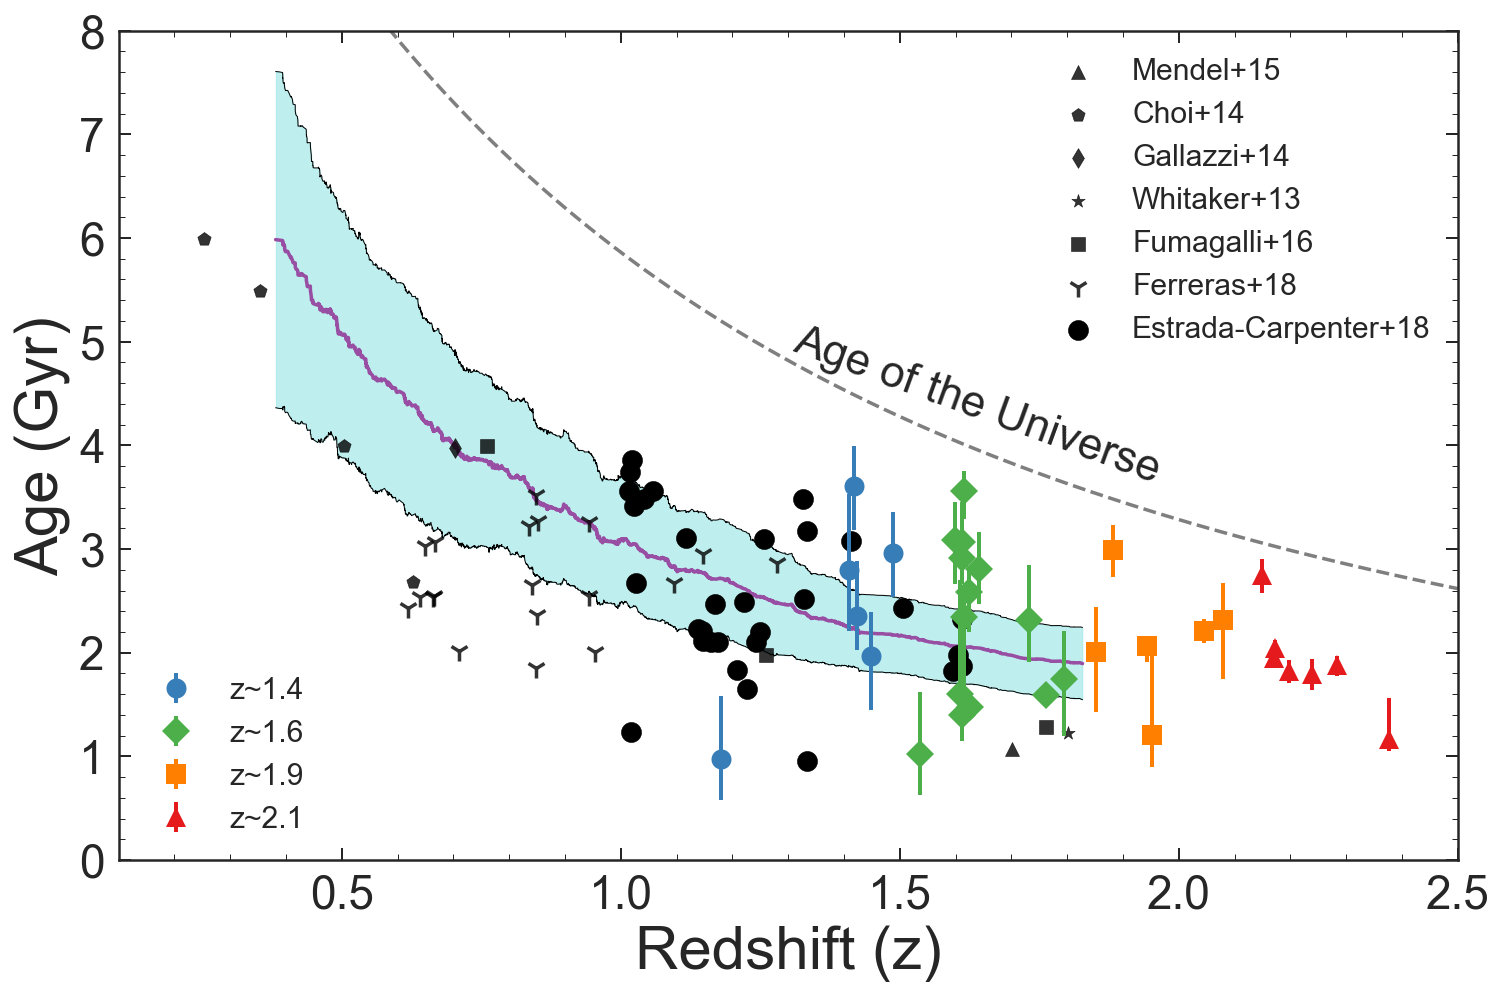

In [78]:
###PLOT
z=np.linspace(0,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^',zorder=2,alpha=0.8)         
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p',zorder=2,alpha=0.8) 
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d',zorder=2,alpha=0.8)       
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*',zorder=2,alpha=0.8)       
ax5=plt.scatter(fumx[6:9],fumy[6:9],color='k',zorder=2,marker='s',alpha=0.8)
ax6=plt.scatter(ferrdb['z'],ferrdb['age'].values,color='k',zorder=2,marker='1',s=100,alpha=0.8)

###vecpoints
ax7=plt.scatter(z_v,age_v,color='k',zorder=2,marker='o',s=100,)

###allpoints
plt.errorbar(lzDB['z_grism'],lzDB.tx,yerr=[lzDB['tx_l'],lzDB['tx_h']],
             color='#377eb8',elinewidth=2,ms=10,fmt='o',zorder=3,label = 'z~1.4')
plt.errorbar(mzDB['z_grism'],mzDB.tx,yerr=[mzDB['tx_l'],mzDB['tx_h']],
             color='#4daf4a',elinewidth=2,ms=10,fmt='D',zorder=3,label = 'z~1.6')
plt.errorbar(hzDB['z_grism'],hzDB.tx,yerr=[hzDB['tx_l'],hzDB['tx_h']],
             color='#ff7f00',elinewidth=2,ms=10,fmt='s',zorder=3,label = 'z~1.9')
plt.errorbar(uhzDB['z_grism'],uhzDB.tx,yerr=[uhzDB['tx_l'],uhzDB['tx_h']],
             color='#e41a1c',elinewidth=2,ms=10,fmt='^',zorder=3,label = 'z~2.2')

# #### millenium
plt.plot(z_g[IDW],rmean,color = '#984ea3',zorder=1)
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5,zorder=1)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5,zorder=1)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,zorder=1)

# handles, labelys = currentAxis.get_legend_handles_labels()
# handles = np.array(handles)
# labels = np.array(labels)
# IDX = np.array([2,3,4,5,1,0])

plt.axis([0.1,2.5,0,8])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5,ax6,ax7],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16','Ferreras+18','Estrada-Carpenter+18'],
              fontsize=15)
plt.legend(loc = 3, fontsize=15)
currentAxis.add_artist(l1)
# plt.savefig('../plots/agevz_featgroup_all_dt_8_13.png',bbox_inches = 'tight')




# Metallicity

In [53]:
GSD_cat = Table.read('/Users/vestrada/Data/3D-HST/CATALOGS/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii')
GND_cat = Table.read('/Users/vestrada/Data/3D-HST/CATALOGS/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii')

In [58]:
lmass = []

for i in galDB.index:
    if galDB.field[i] == 'GSD':
        lmass.append(GSD_cat[galDB.ids[i] - 1]['lmass'])
    if galDB.field[i] == 'GND':
        lmass.append(GND_cat[galDB.ids[i] - 1]['lmass'])


In [59]:
galDB['lmass'] = lmass

In [60]:
# galDB.to_pickle('../dataframes/galaxy_database.pkl')

In [79]:
"""DATA"""
def Linear_fit(x,Y,sig,new_x,return_cov = False):
    A=np.array([np.ones(len(x)),x]).T
    C =np.diag(sig**2)
    iC=inv(C)
    b,m = np.dot(inv(np.dot(np.dot(A.T,iC),A)),np.dot(np.dot(A.T,iC),Y))
    cov = inv(np.dot(np.dot(A.T,iC),A))
    var_b = cov[0][0]
    var_m = cov[1][1]
    sig_mb = cov[0][1]
    sig_y = np.sqrt(var_b + new_x**2*var_m + 2*new_x*sig_mb)
    if return_cov == True:
        return m*new_x+b , sig_y, cov
    else:
        return m*new_x+b , sig_y

logm,gmetal=np.loadtxt('../../Quiescent_analysis/data/Gallazzi_12.dat').T
cvx,cvy=np.loadtxt('../../Quiescent_analysis/data/Gallazzi_12_line.dat').T
cv1x,cv1y=np.loadtxt('../../Quiescent_analysis/data/gallazzi_points_curve1.dat').T

gid_v, z_v, lmass_v, age_v, age_le_v, age_le_v, Z_v, Z_le_v, Z_he_v = np.loadtxt(
    '../../Quiescent_analysis/data/vec_CLEARI_measurements.dat',skiprows=1,dtype=np.str).T   

lmass_v = lmass_v.astype(float)
Z_v = Z_v.astype(float)
Z_le_v = Z_le_v.astype(float)
Z_he_v = Z_he_v.astype(float)

errs = ((Z_le_v +Z_he_v)/2) / (Z_v * np.log(10))
samp = np.arange(.9,11.9,.01)
lfit,lfit_errs,cov = Linear_fit(lmass_v,np.log10(Z_v/0.019),errs,samp,return_cov=True)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'N')

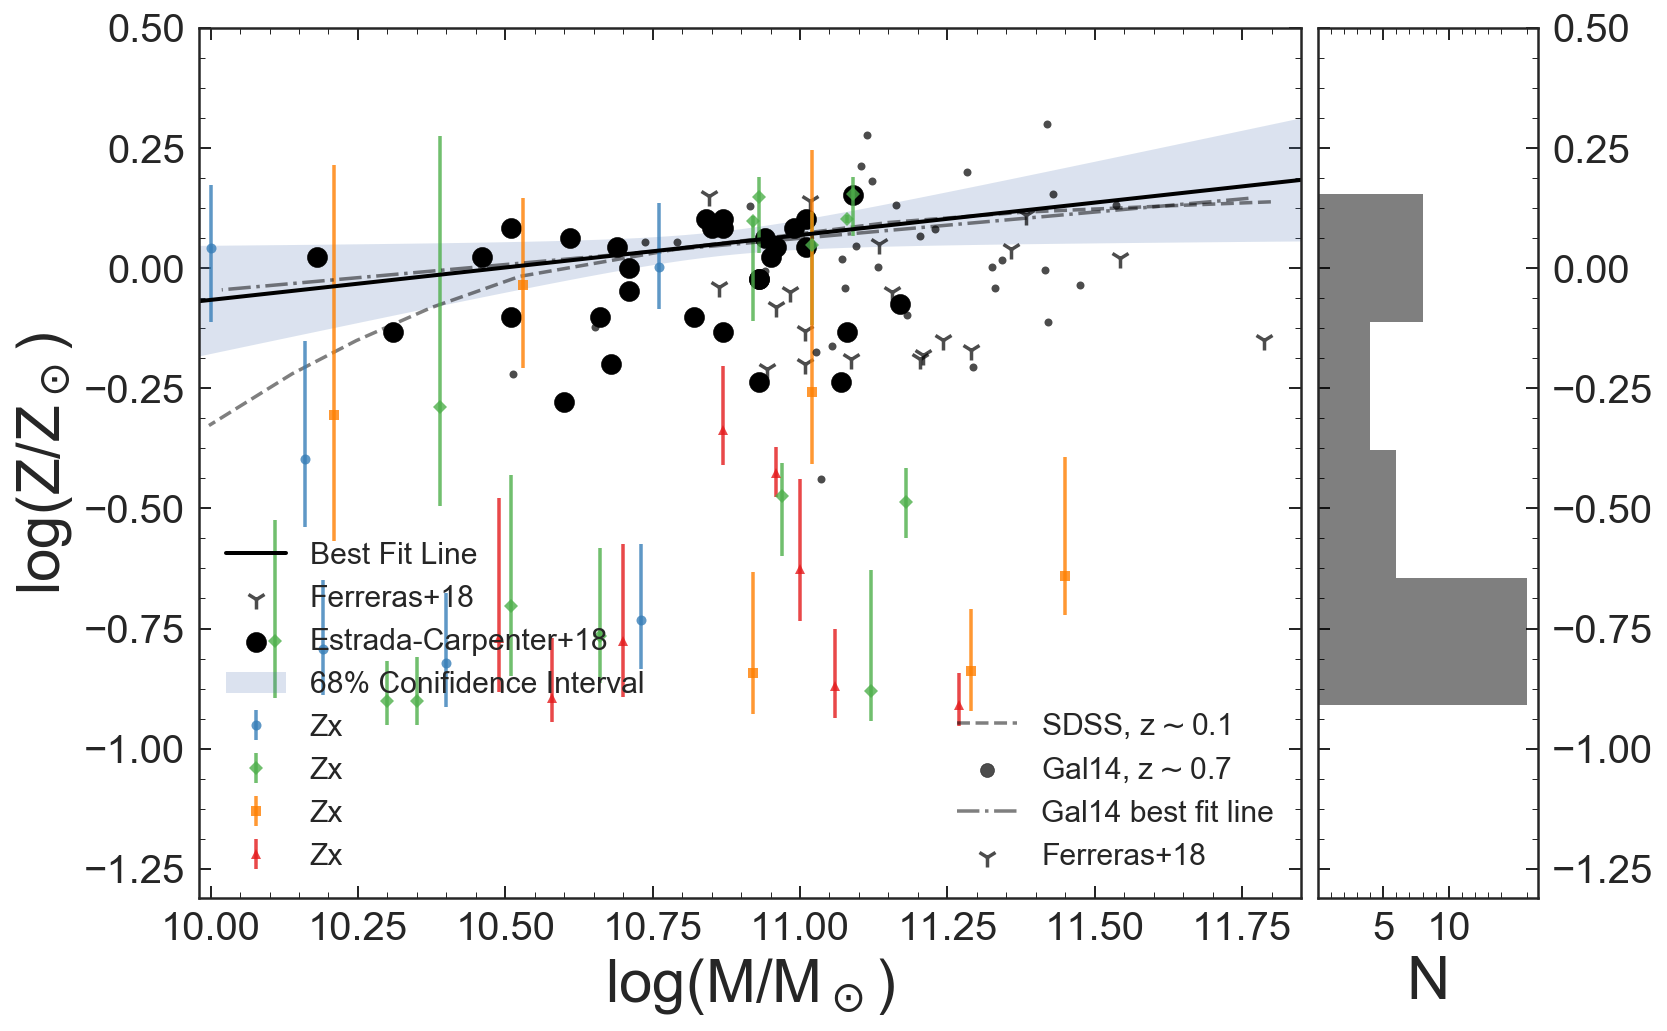

In [81]:
###PLOT
%matplotlib inline

gs = GridSpec(1,2,wspace=0.025,width_ratios=[5,1])

plt.figure(figsize=[12,8])

####gallazzi points
plt.subplot(gs[0])
currentAxis = plt.gca()

plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.5,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.5,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.7,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.7)#,label='Gallazzi+14,z=0.7')
#####ferreras points
ferra = plt.scatter(np.log10(ferrdb['M']*1E11),ferrdb['Z/H'].values,color='k',zorder=2,marker='1',alpha=.7,s=100)


#####vec18 points
vec18 = plt.scatter(lmass_v,np.log10(Z_v/0.019),color='k',zorder=2,marker='o',s=100)

legend1 = plt.legend([sdss,galpts,galbf,ferra,vec18],
                     ['SDSS, z$\sim$0.1','Gal14, z$\sim$0.7','Gal14 best fit line','Ferreras+18','Estrada-Carpenter+18'],
                     loc = 4,fontsize=15)
currentAxis.add_artist(legend1)

#####single galaxy points
zg1 = plt.errorbar(lzDB['lmass'],np.log10(lzDB.Zx/0.019), yerr=[lzDB['Zx_l']/(lzDB['Zx'] * np.log(10)),
            lzDB['Zx_h']/(lzDB['Zx'] * np.log(10))],color='#377eb8',alpha=.8,ms=5,fmt='o',label = 'z~1.4')
zg2 = plt.errorbar(mzDB['lmass'],np.log10(mzDB.Zx/0.019), yerr=[mzDB['Zx_l']/(mzDB['Zx'] * np.log(10)),
            mzDB['Zx_h']/(mzDB['Zx'] * np.log(10))],color='#4daf4a',alpha=.8,ms=5,fmt='D',label = 'z~1.6')
zg3 = plt.errorbar(hzDB['lmass'],np.log10(hzDB.Zx/0.019), yerr=[hzDB['Zx_l']/(hzDB['Zx'] * np.log(10)),
            hzDB['Zx_h']/(hzDB['Zx'] * np.log(10))],color='#ff7f00',alpha=.8,ms=5,fmt='s',label = 'z~1.9')
zg4 = plt.errorbar(uhzDB['lmass'],np.log10(uhzDB.Zx/0.019), yerr=[uhzDB['Zx_l']/(uhzDB['Zx'] * np.log(10)),
            uhzDB['Zx_h']/(uhzDB['Zx'] * np.log(10))],color='#e41a1c',alpha=.8,ms=5,fmt='^',label = 'z~2.2')

legend1 = plt.legend([zg1,zg2,zg3,zg4],
                     ['z~1.4','z~1.4','z~1.4','z~1.4'],
                     loc = 4,fontsize=15)
### best fit line
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([9.98,11.85,-1.31,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
currentAxis.xaxis.set_minor_locator(plt.MultipleLocator(0.05))

plt.legend(loc=3,fontsize=15)

plt.subplot(gs[1])
sea.distplot(np.log10(galDB.Zx.values/0.019),vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k',"label":'This Work'})

plt.ylim(-1.31,.5)
plt.gca().tick_params(axis='y',labelleft='off',labelright='on')
plt.xticks([5,10])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('N',size=30)
# plt.legend(fontsize=15)

# plt.savefig('../plots/metalmass_featgroup_8_13.eps',bbox_inches = 'tight')